In [ ]:
!unzip /content/drive/MyDrive/pothole600_v3.zip -d pothole600_v3

In [ ]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output



In [ ]:
len(glob.glob("/content/pothole600_v3/training/label/*"))

1320

In [ ]:
len(glob.glob("/content/pothole600_v3/training/rgb/*"))

1320

In [ ]:
rgb = glob.glob("/content/pothole600_v3/training/rgb/*")
labels = glob.glob("/content/pothole600_v3/training/label/*")
ids_train = next(os.walk("/content/pothole600_v3/training/rgb"))[2] # list of names all images in the given path



for i in range(len(labels)):
  image = cv2.imread(rgb[i])
  label = cv2.imread(labels[i])
  noise_img_3 = sp_noise(image,0.3)
  cv2.imwrite(f'/content/pothole600_v3/training/rgb/noise_img_3{ids_train[i]}', noise_img_3)
  cv2.imwrite(f'/content/pothole600_v3/training/label/noise_img_3{ids_train[i]}', label)

  noise_img_6 = sp_noise(image,0.6)
  cv2.imwrite(f'/content/pothole600_v3/training/rgb/noise_img_6{ids_train[i]}', noise_img_6)
  cv2.imwrite(f'/content/pothole600_v3/training/label/noise_img_6{ids_train[i]}', label)

  noise_img_9 = sp_noise(image,0.9)
  cv2.imwrite(f'/content/pothole600_v3/training/rgb/noise_img_9{ids_train[i]}', noise_img_9)
  cv2.imwrite(f'/content/pothole600_v3/training/label/noise_img_9{ids_train[i]}', label)


  blurred_imgs = [cv2.blur(image, (sigma, sigma))  for sigma in (3,7)]
  cv2.imwrite(f'/content/pothole600_v3/training/rgb/blurred_imgs_3{ids_train[i]}', blurred_imgs[0])
  cv2.imwrite(f'/content/pothole600_v3/training/label/blurred_imgs_3{ids_train[i]}', label)


  cv2.imwrite(f'/content/pothole600_v3/training/rgb/blurred_imgs_7{ids_train[i]}', blurred_imgs[1])
  cv2.imwrite(f'/content/pothole600_v3/training/label/blurred_imgs_7{ids_train[i]}', label)

In [ ]:
len(glob.glob("/content/pothole600_v3/training/label/*")), len(glob.glob("/content/pothole600_v3/training/rgb/*"))




(7935, 7935)

In [ ]:
import shutil
shutil.make_archive('/content/drive/MyDrive/pothole600_v4', 'zip', '/content/pothole600_v3')

'/content/drive/MyDrive/pothole600_v4.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/pothole600_v4.zip -d pothole600_v4

In [ ]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm_notebook#, tnrange
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from skimage.transform import resize
from skimage.morphology import label
# from itertools import chain
from skimage.io import imread, imshow#, concatenate_images
from keras.models import Model, load_model
from keras.layers.pooling import MaxPooling2D#, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, concatenate, add
# from keras.layers.core import Lambda, RepeatVector, Reshape



plt.style.use("ggplot")
%matplotlib inline

In [ ]:
# Set some parameters
im_width = 320
im_height = 320


In [ ]:
def get_df(path):

    image = [f'{path}/rgb/{i}' for i in next(os.walk(f'{path}/rgb'))[2]]
    mask_map = [f'{path}/label/{i}' for i in next(os.walk(f'{path}/label'))[2]]
    df = pd.DataFrame(columns=['image', 'mask'])
    df['image'] = image
    df['mask'] = mask_map
    return df


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, dataframe, batch_size, shuffle=False, dim=(320,320)):
    # for reproducibility
    np.random.seed(43)
    # dataframe containing the subset of image and depth pairs
    self.df = dataframe
    # chosen Height and Width of the RGB image
    self.height, self.width = dim
    # choice of shuffling the data
    self.shuffle = shuffle
    self.batch_size = batch_size
    # unique set of RGB images
    self.ids = dataframe['image'].unique()
    # Map the image with depth maps
    self.imgtodpth = dataframe.set_index('image')['mask'].to_dict()
    self.on_epoch_end()

  def __len__(self):
    '''
    Returns the length of dataset.
    '''
    return len(self.df) // self.batch_size

  def on_epoch_end(self):
    '''
    Shuffles the data at the end of every epoch
    '''
    self.indexes = np.arange(len(self.ids))
    if self.shuffle:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self,index):
    '''
    returns the batch of image and depth pairs 
    '''
    # select the batch of pair indexes 
    idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
    # randomly select whether to flip the image
    flip = np.random.choice([True, False])
    # select the image id's for the above indexes
    query_imgs = [self.ids[idx] for idx in idxs]
    # select corresponding depth pair for the image
    target_imgs = [self.imgtodpth[img] for img in query_imgs]
    # preprocess the image 
    processed_query_img = self._preprocess_image(query_imgs, flip)
    # preprocess the depth map
    processed_depth_img = self._preprocess_depth(target_imgs, flip)
    return processed_query_img, processed_depth_img

  def _preprocess_image(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the image set. 
    '''
    # placeholder for storing the processed images
    processed = []
    for img in images:
      # resize the image to 640x480
      resized_img = cv2.resize(cv2.imread(img),(self.height,self.width)).astype(np.float32)
      # normalize the image to {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # finally append each image
      processed.append(scaled_img)
    return np.array(processed)

  def _preprocess_depth(self,images, flip):
    '''
    Resize, Normalize and randomly Augments the depth maps.
    '''
    # placeholder for storing the processed depth maps
    processed = []
    for img in images:
      # resize the depth map to 320x240
      resized_img = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY),(320,320)).astype(np.float32)
      # normalize it to range {0,1}
      scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
      # flip the image horizontally
      if flip:
        scaled_img = cv2.flip(scaled_img, 1)
      # add the color channel as cv2 grayscale image doesnt contain color channel but tensorflow expects it
      scaled_img = np.expand_dims(scaled_img, axis=-1)
      # finally append the image
      processed.append(scaled_img)
    return np.array(processed)
    


In [ ]:


def conv2d_block(input_tensor, n_filters, kernel_size = 3, activation='relu', batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    return x



def upsampling(input_tensor, n_filters, concat_layer, activation='relu'):
    '''
    Block of Decoder
    '''
    x = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(input_tensor)
    x = concatenate([x, concat_layer])
    x = Dropout(0.2)(x)
    x = conv2d_block(x, n_filters, kernel_size = 3, activation=activation, batchnorm = True)
    return x


def DenseNet_UNET(n_filters, activation):


    ########################################################

                    #ENCODER#

    # Layer name of encoders to be concatenated
    names = ['pool3_pool', 'pool2_pool', 'pool1','conv1/relu']
    # Transfer learning approach without the classification head
    encoder = DenseNet201(include_top=False, weights='imagenet', input_shape=(320,320,3))
    for layer in encoder.layers:
      layer.trainable = True
      inputs = encoder.input
      x = encoder.output

                    #ENCODER#

    ########################################################


    ########################################################

                    #bottleneck#


    # decoder blocks linked with corresponding encoder blocks
    bneck = Conv2D(filters=n_filters*16, kernel_size=(1,1), padding='same')(x)
    x = Activation(activation)(bneck)                    

                    #bottleneck#

    ########################################################


    ########################################################

                    #DECODER#

    x = upsampling(input_tensor=bneck, n_filters=n_filters*16, activation=activation, concat_layer=encoder.get_layer(names[0]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*8, activation=activation, concat_layer=encoder.get_layer(names[1]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*4, activation=activation, concat_layer=encoder.get_layer(names[2]).output)
    x = upsampling(input_tensor=x, n_filters=n_filters*2, activation=activation, concat_layer=encoder.get_layer(names[3]).output)
    x = Conv2DTranspose(n_filters*2, (3, 3), strides = (2, 2), padding = 'same')(x)
    x = Activation(activation)(x)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

                    #DECODER#

    ########################################################

    model = Model(inputs=inputs, outputs=x)
    return model

In [ ]:
train = get_df('/content/pothole600_v4/training')
val = get_df('/content/pothole600_v4/validation')
test = get_df('/content/pothole600_v4/testing')


In [ ]:
train_generator = DataGenerator(train, batch_size=12, shuffle=True, dim=(320,320))
val_generator = DataGenerator(val, batch_size=12, shuffle=False, dim=(320,320))
test_generator = DataGenerator(test, batch_size=5, shuffle=False, dim=(320,320))
print(len(train_generator), len(val_generator), len(test_generator))

661 6 16


In [ ]:
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

(12, 320, 320, 3) (12, 320, 320, 1)


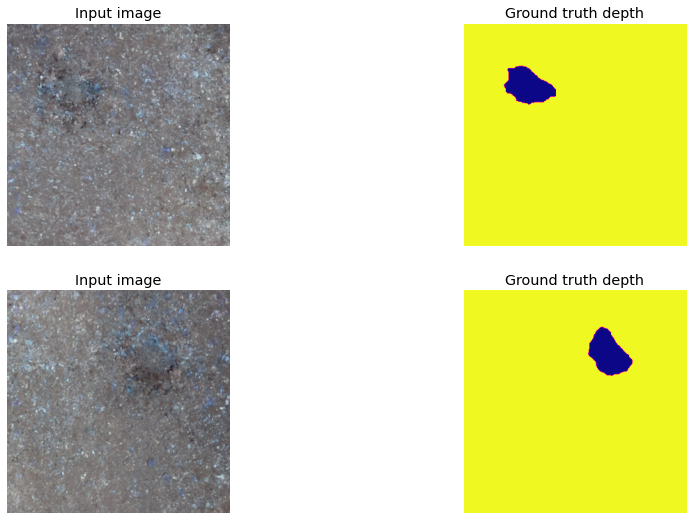

In [ ]:
cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
  image = images[i]
  depth = depths[i].squeeze(-1)
  plt.subplot(221+i)
  plt.axis('off')
  plt.imshow(image)
  plt.title('Input image')
  plt.subplot(222+i)
  plt.axis('off')
  plt.imshow(depth,cmap=plt.get_cmap(cmap))
  plt.title('Ground truth depth')

In [ ]:
model = DenseNet_UNET(64, LeakyReLU(0.2))


74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Label-MODEL-WITH-agumentation-ex1.h5', verbose=1
                    , save_best_only=True, save_weights_only=True)]




In [ ]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.BinaryIoU(), 
                  tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50,callbacks=callbacks)

Epoch 1/50
661/661 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9397 - binary_io_u: 0.6044 - precision: 0.7138 - recall: 0.2986
Epoch 1: val_loss improved from inf to 0.07122, saving model to /content/drive/MyDrive/Label-MODEL-WITH-agumentation-ex1.h5
661/661 [==============================] - 787s 1s/step - loss: 0.1763 - accuracy: 0.9397 - binary_io_u: 0.6044 - precision: 0.7138 - recall: 0.2986 - val_loss: 0.0712 - val_accuracy: 0.9760 - val_binary_io_u: 0.6705 - val_precision: 0.6142 - val_recall: 0.4653 - lr: 0.0010
Epoch 2/50
661/661 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9507 - binary_io_u: 0.6779 - precision: 0.7954 - recall: 0.4500
Epoch 2: val_loss improved from 0.07122 to 0.03373, saving model to /content/drive/MyDrive/Label-MODEL-WITH-agumentation-ex1.h5
661/661 [==============================] - 784s 1s/step - loss: 0.1429 - accuracy: 0.9507 - binary_io_u: 0.6779 - precision: 0.7954 - recall: 0.4500 - val_loss: 0.

In [ ]:
model.load_weights('/content/drive/MyDrive/Label-MODEL-WITH-agumentation-ex1.h5')

In [ ]:
model.evaluate(test_generator)

16/16 [==============================] - 184s 11s/step - loss: 0.0419 - accuracy: 0.9833 - binary_io_u: 0.9145 - precision: 0.9441 - recall: 0.8896


[0.041877515614032745,
 0.9832637906074524,
 0.9145281910896301,
 0.9440910816192627,
 0.8896071314811707]

In [ ]:
images,labels = next(iter(test_generator))
preds = model.predict(images)

1/1 [==============================] - 15s 15s/step


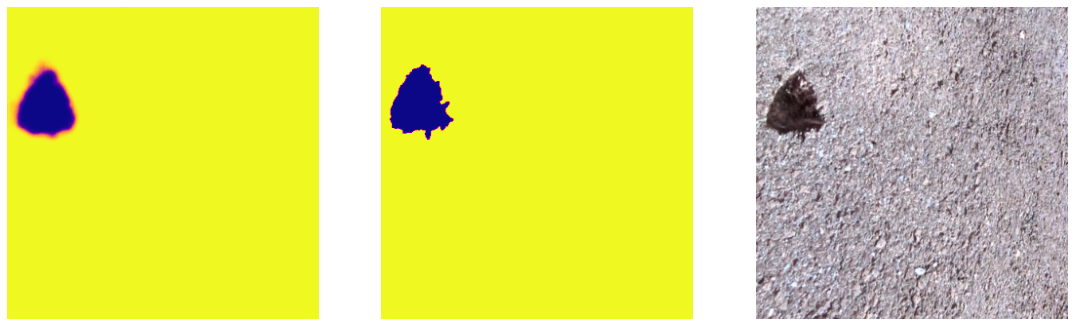

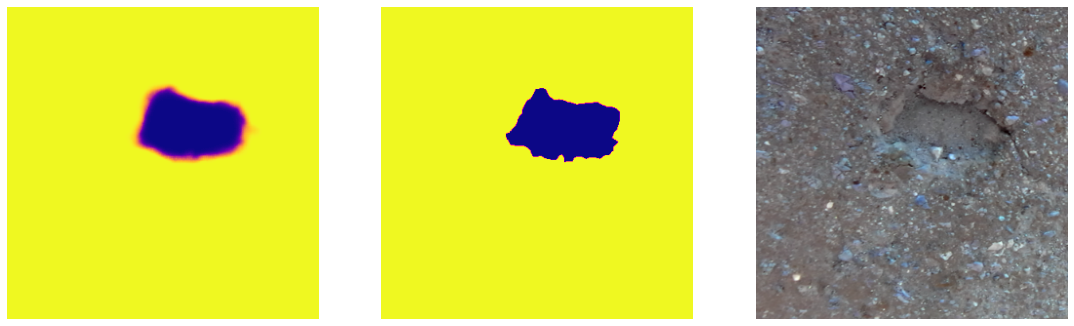

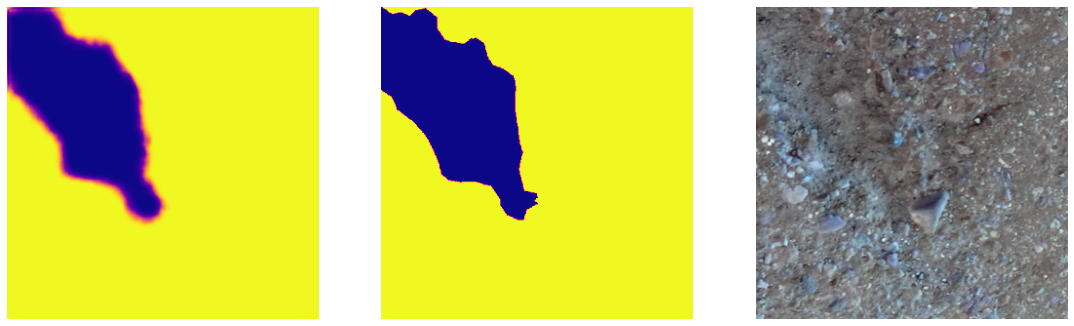

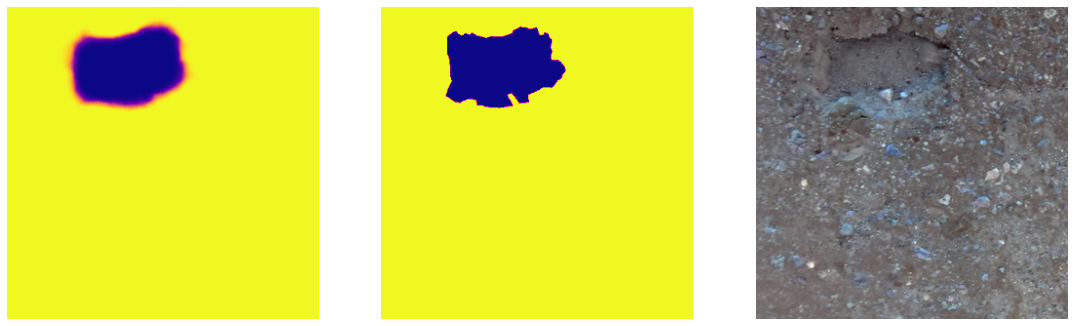

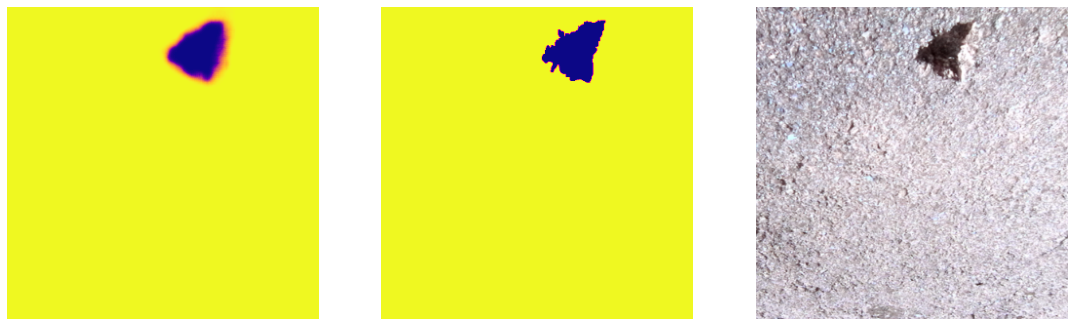

In [ ]:
cmap = "plasma_r"


for i in range(len(images)):
  plt.figure(figsize=(19,10))
  pred = preds[i]
  pred = np.squeeze(pred, axis=-1)
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.imshow(pred, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,2)
  plt.axis("off")
  img = labels[i]
  img = np.squeeze(img, axis=-1)
  plt.imshow(img, cmap=plt.get_cmap(cmap))

  plt.subplot(1,3,3)
  plt.axis("off")
  img1 = images[i]
  plt.imshow(img1)

  plt.show()